In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
# We used 17000 data for this
# Load the file
file_path = r"F:\programming\17000 data.txt"

# Read lines that contain table data
with open(file_path, 'r', encoding='utf-8') as file:
    lines = [line.strip() for line in file if line.strip().startswith('|')]

# Parse table content
rows = [line.split('|')[1:-1] for line in lines]
rows = [[cell.strip() for cell in row] for row in rows]

# Extract header and data
header = rows[0]
all_data = pd.DataFrame(rows[1:], columns=header)

# Drop the first column (Circuit #)
data = all_data.iloc[:, 1:].copy()

# Convert to numeric where applicable
for col in data.columns[:-1]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with NaNs
data = data.dropna()

# Features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Filter top 10 simulators
top_10_simulators = y.value_counts()[y.value_counts() >= 2].head(10).index
mask = y.isin(top_10_simulators)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("Top 10 simulators selected:", list(top_10_simulators))

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
# Train classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.4f" % acc)

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validated Accuracy: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))


Top 10 simulators selected: ['ibmq_sherbrooke', 'ibmq_prague', 'ibmq_quebec', 'ibmq_marrakesh', 'ibmq_peekskill', 'ibmq_sydney', 'ibmq_singapore', 'ibmq_manhattan', 'ibmq_poughkeepsie', 'ibmq_washington']
Test Accuracy: 0.2133
Cross-validated Accuracy: 0.2040 ± 0.0043


In [3]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train XGBoost
model = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train_enc)
y_pred = model.predict(X_test)
print("XGBoost Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


XGBoost Accuracy: 0.1859


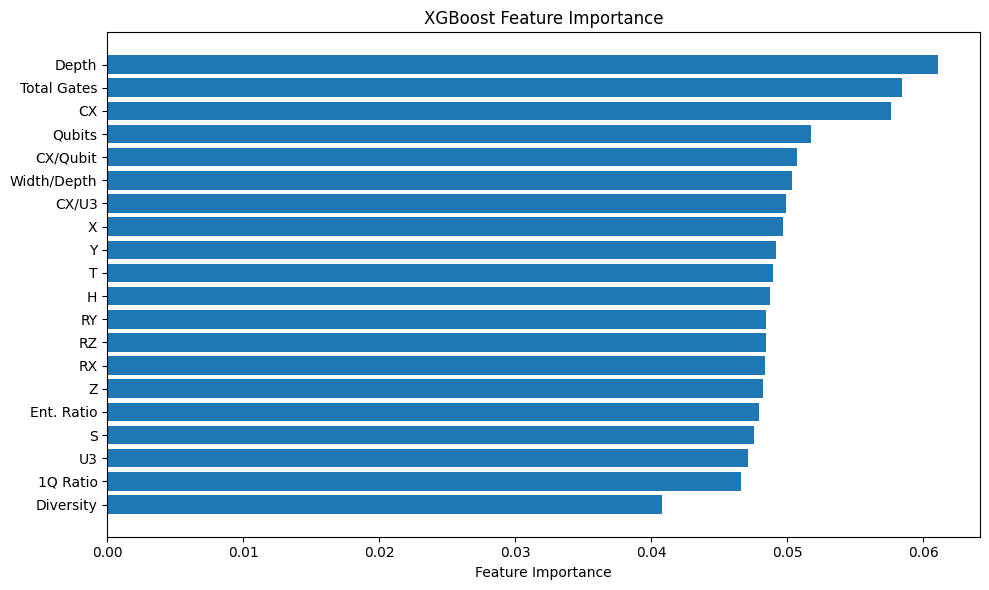

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from XGBoost
importances = model.feature_importances_
feature_names = X.columns

# Sort and plot
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


In [5]:
print(y.value_counts(normalize=True))


Best Simulator
ibmq_sherbrooke      0.202335
ibmq_prague          0.201710
ibmq_quebec          0.146660
ibmq_marrakesh       0.133315
ibmq_peekskill       0.074095
ibmq_sydney          0.069299
ibmq_singapore       0.064850
ibmq_manhattan       0.042260
ibmq_poughkeepsie    0.033920
ibmq_washington      0.031556
Name: proportion, dtype: float64


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assume X and y are already defined
scaler = StandardScaler()
X_scaled_reduced = scaler.fit_transform(X)  # scale your input features


# Train/test split (already scaled: X_scaled_reduced)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reduced, y, test_size=0.2, random_state=42)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train logistic regression
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train_enc)

# Predict and evaluate
y_pred = logreg.predict(X_test)
print("Logistic Regression Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.2227


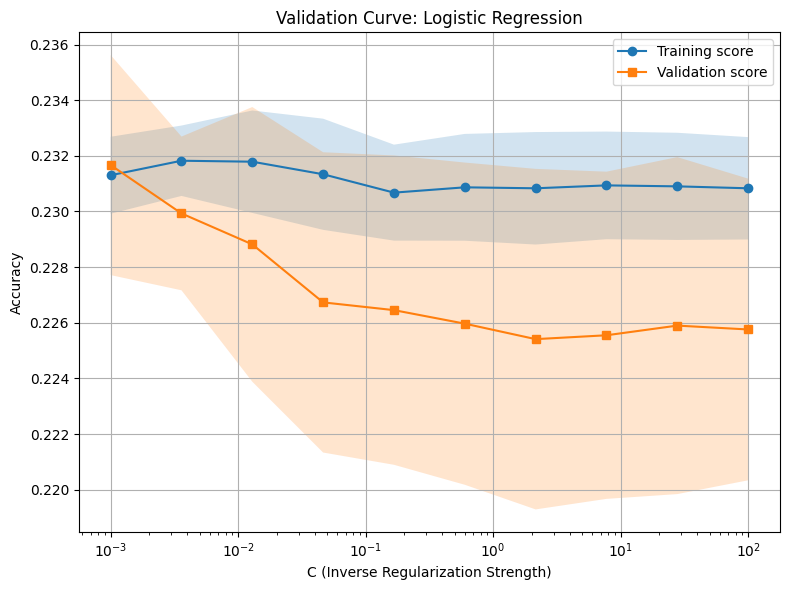

In [7]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Range of C values (log scale)
param_range = np.logspace(-3, 2, 10)

# Compute validation curve
train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    X_scaled_reduced, le.fit_transform(y),
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Means and std for plotting
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.semilogx(param_range, train_mean, label='Training score', marker='o')
plt.semilogx(param_range, val_mean, label='Validation score', marker='s')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve: Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Final Logistic Regression with best C
best_logreg = LogisticRegression(C=0.001, max_iter=1000,solver='lbfgs')
best_logreg.fit(X_train, y_train_enc)

# Evaluate
y_pred = best_logreg.predict(X_test)
from sklearn.metrics import accuracy_score
print("Tuned Logistic Regression Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Tuned Logistic Regression Accuracy: 0.2238


Degree 1 - Accuracy: 0.2238
Degree 2 - Accuracy: 0.2161
Degree 3 - Accuracy: 0.2252
Degree 4 - Accuracy: 0.2234
Degree 5 - Accuracy: 0.2182
Degree 6 - Accuracy: 0.2144
Degree 7 - Accuracy: 0.2078
Degree 8 - Accuracy: 0.2033
Degree 9 - Accuracy: 0.2001
Degree 10 - Accuracy: 0.1953


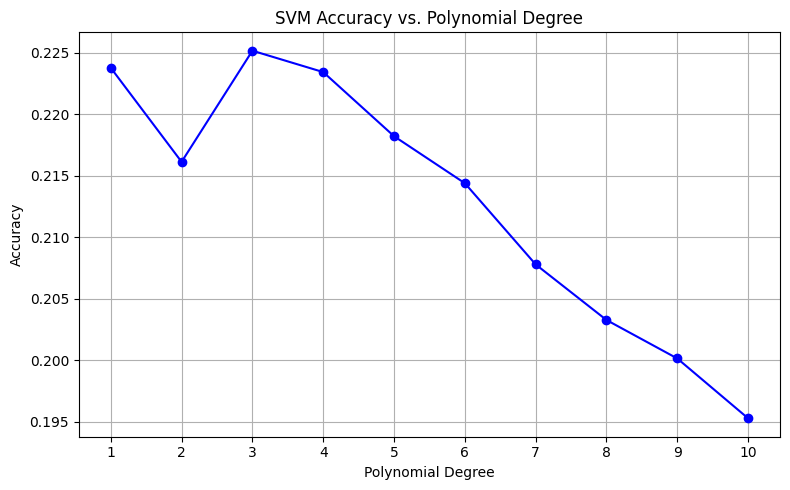

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

degrees = range(1, 11)
accuracies = []

for d in degrees:
    svm_poly = SVC(kernel='poly', degree=d, C=1.0, gamma='scale', decision_function_shape='ovr', random_state=42)
    svm_poly.fit(X_train, y_train_enc)
    y_pred = svm_poly.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"Degree {d} - Accuracy: {acc:.4f}")

# Plot accuracy vs. polynomial degree
plt.figure(figsize=(8, 5))
plt.plot(degrees, accuracies, marker='o', linestyle='-', color='blue')
plt.title("SVM Accuracy vs. Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(degrees)
plt.tight_layout()
plt.show()


k = 1, Accuracy = 0.1557
k = 2, Accuracy = 0.1612
k = 3, Accuracy = 0.1505
k = 4, Accuracy = 0.1494
k = 5, Accuracy = 0.1584
k = 6, Accuracy = 0.1640
k = 7, Accuracy = 0.1689
k = 8, Accuracy = 0.1734
k = 9, Accuracy = 0.1668
k = 10, Accuracy = 0.1737
k = 11, Accuracy = 0.1800
k = 12, Accuracy = 0.1800
k = 13, Accuracy = 0.1727
k = 14, Accuracy = 0.1765
k = 15, Accuracy = 0.1828
k = 16, Accuracy = 0.1803
k = 17, Accuracy = 0.1911
k = 18, Accuracy = 0.1946
k = 19, Accuracy = 0.1953
k = 20, Accuracy = 0.1904
k = 21, Accuracy = 0.1894
k = 22, Accuracy = 0.1935
k = 23, Accuracy = 0.1915
k = 24, Accuracy = 0.1956
k = 25, Accuracy = 0.1967
k = 26, Accuracy = 0.1921
k = 27, Accuracy = 0.1977
k = 28, Accuracy = 0.1946
k = 29, Accuracy = 0.1935
k = 30, Accuracy = 0.1956
k = 31, Accuracy = 0.1998
k = 32, Accuracy = 0.2005
k = 33, Accuracy = 0.2057
k = 34, Accuracy = 0.2116
k = 35, Accuracy = 0.2140
k = 36, Accuracy = 0.2144
k = 37, Accuracy = 0.2168
k = 38, Accuracy = 0.2130
k = 39, Accuracy = 0.

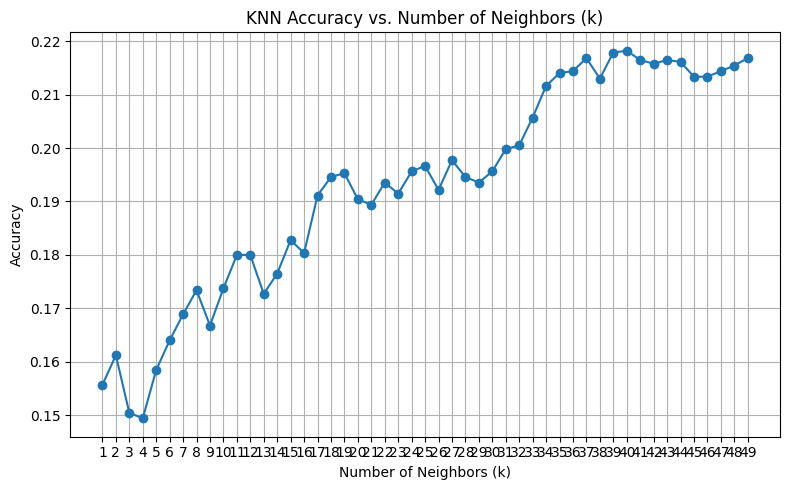

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Try k values from 1 to 30
k_values = range(1, 50)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train_enc)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Final KNN model
best_knn = KNeighborsClassifier(n_neighbors=37)
best_knn.fit(X_train, y_train_enc)
y_pred = best_knn.predict(X_test)

# Evaluate
print("Final KNN Accuracy (k=37): %.4f" % accuracy_score(y_test_enc, y_pred))


Final KNN Accuracy (k=37): 0.2168


k = 1, Accuracy = 0.1557
k = 2, Accuracy = 0.1557
k = 3, Accuracy = 0.1602
k = 4, Accuracy = 0.1640
k = 5, Accuracy = 0.1706
k = 6, Accuracy = 0.1710
k = 7, Accuracy = 0.1699
k = 8, Accuracy = 0.1765
k = 9, Accuracy = 0.1744
k = 10, Accuracy = 0.1817
k = 11, Accuracy = 0.1873
k = 12, Accuracy = 0.1897
k = 13, Accuracy = 0.1817
k = 14, Accuracy = 0.1800
k = 15, Accuracy = 0.1855
k = 16, Accuracy = 0.1866
k = 17, Accuracy = 0.1901
k = 18, Accuracy = 0.1901
k = 19, Accuracy = 0.1946
k = 20, Accuracy = 0.1928
k = 21, Accuracy = 0.1932
k = 22, Accuracy = 0.2001
k = 23, Accuracy = 0.1970
k = 24, Accuracy = 0.1967
k = 25, Accuracy = 0.1994
k = 26, Accuracy = 0.1963
k = 27, Accuracy = 0.2005
k = 28, Accuracy = 0.2008
k = 29, Accuracy = 0.1987
k = 30, Accuracy = 0.1984
k = 31, Accuracy = 0.1967
k = 32, Accuracy = 0.1998
k = 33, Accuracy = 0.2008
k = 34, Accuracy = 0.2081
k = 35, Accuracy = 0.2088
k = 36, Accuracy = 0.2067
k = 37, Accuracy = 0.2137
k = 38, Accuracy = 0.2133
k = 39, Accuracy = 0.

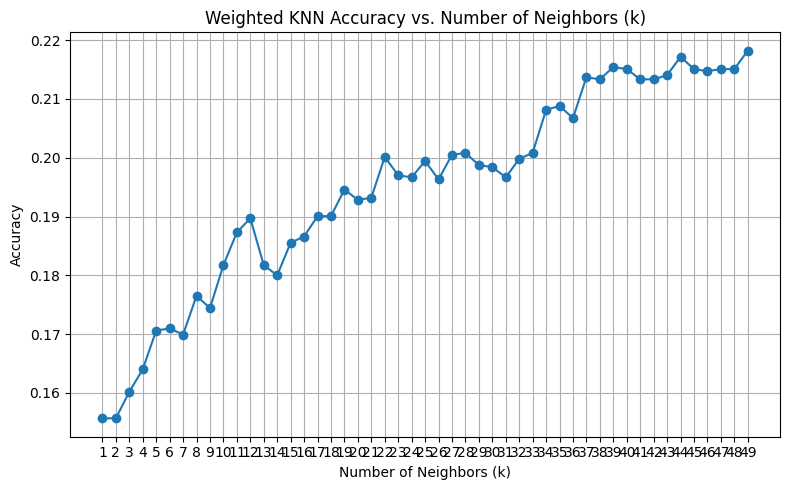

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Try k values from 1 to 50 with weighted distance
k_values = range(1, 50)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train_enc)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title("Weighted KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [14]:
best_knn_weighted = KNeighborsClassifier(n_neighbors=34, weights='distance')
best_knn_weighted.fit(X_train, y_train_enc)
y_pred = best_knn_weighted.predict(X_test)

from sklearn.metrics import accuracy_score
print("Final Weighted KNN Accuracy (k=34): %.4f" % accuracy_score(y_test_enc, y_pred))


Final Weighted KNN Accuracy (k=34): 0.2081


max_depth=3, n_estimators=10 → Accuracy: 0.2224
max_depth=3, n_estimators=50 → Accuracy: 0.2245
max_depth=3, n_estimators=100 → Accuracy: 0.2259
max_depth=3, n_estimators=150 → Accuracy: 0.2269
max_depth=3, n_estimators=200 → Accuracy: 0.2262
max_depth=3, n_estimators=250 → Accuracy: 0.2248
max_depth=3, n_estimators=300 → Accuracy: 0.2248
max_depth=3, n_estimators=350 → Accuracy: 0.2248
max_depth=3, n_estimators=400 → Accuracy: 0.2248
max_depth=4, n_estimators=10 → Accuracy: 0.2252
max_depth=4, n_estimators=50 → Accuracy: 0.2279
max_depth=4, n_estimators=100 → Accuracy: 0.2283
max_depth=4, n_estimators=150 → Accuracy: 0.2262
max_depth=4, n_estimators=200 → Accuracy: 0.2269
max_depth=4, n_estimators=250 → Accuracy: 0.2259
max_depth=4, n_estimators=300 → Accuracy: 0.2255
max_depth=4, n_estimators=350 → Accuracy: 0.2252
max_depth=4, n_estimators=400 → Accuracy: 0.2255
max_depth=5, n_estimators=10 → Accuracy: 0.2175
max_depth=5, n_estimators=50 → Accuracy: 0.2206
max_depth=5, n_estimators=

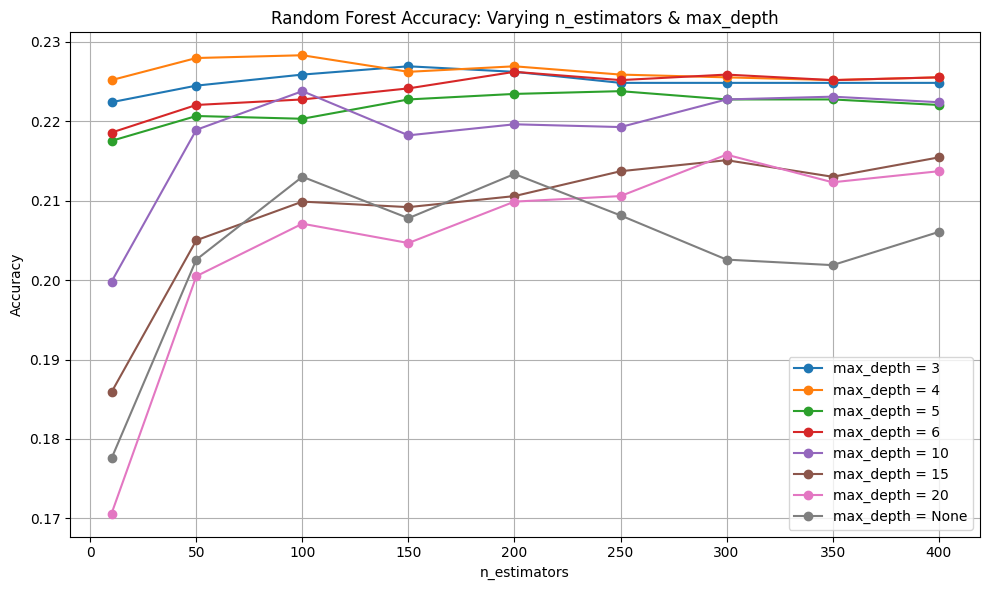

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Parameter ranges
n_estimators_range = [10,50, 100, 150, 200, 250,300,350,400]
max_depth_range = [3,4,5,6, 10, 15, 20, None]

# Store results
results = {}

# Evaluate all combinations
for depth in max_depth_range:
    acc_list = []
    for n in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train_enc)
        y_pred = rf.predict(X_test)
        acc = accuracy_score(y_test_enc, y_pred)
        acc_list.append(acc)
        print(f"max_depth={depth}, n_estimators={n} → Accuracy: {acc:.4f}")
    results[str(depth)] = acc_list

# Plotting
plt.figure(figsize=(10, 6))
for depth, accs in results.items():
    label = f"max_depth = {depth}"
    plt.plot(n_estimators_range, accs, marker='o', label=label)

plt.title("Random Forest Accuracy: Varying n_estimators & max_depth")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Best RF model
rf_final = RandomForestClassifier(
    n_estimators=350,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train, y_train_enc)
y_pred = rf_final.predict(X_test)

print("Final Random Forest Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Final Random Forest Accuracy: 0.2252


C = 0.01, Accuracy = 0.2252
C = 0.10, Accuracy = 0.2245
C = 0.50, Accuracy = 0.2234
C = 1.00, Accuracy = 0.2262
C = 2.00, Accuracy = 0.2227
C = 5.00, Accuracy = 0.2165


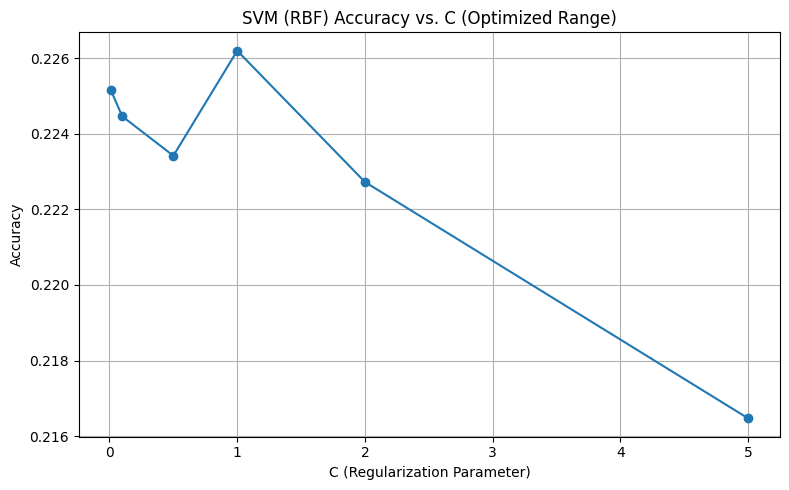

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Smarter C range
c_values = [0.01, 0.1, 0.5, 1, 2, 5]
accuracies = []

for c in c_values:
    svm_model = SVC(kernel='rbf', C=c, gamma='scale', decision_function_shape='ovr', random_state=42)
    svm_model.fit(X_train, y_train_enc)
    y_pred = svm_model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"C = {c:.2f}, Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(c_values, accuracies, marker='o', linestyle='-')
plt.title("SVM (RBF) Accuracy vs. C (Optimized Range)")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

final_svm = SVC(kernel='rbf', C=0.01, gamma='scale', decision_function_shape='ovr', random_state=42)
final_svm.fit(X_train, y_train_enc)
y_pred = final_svm.predict(X_test)

print("Final Tuned SVM Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Final Tuned SVM Accuracy: 0.2252


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.01, n_estimators=100 → Accuracy: 0.2126


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.01, n_estimators=200 → Accuracy: 0.2133


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.01, n_estimators=300 → Accuracy: 0.2113


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.05, n_estimators=100 → Accuracy: 0.2081


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.05, n_estimators=200 → Accuracy: 0.2054


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.05, n_estimators=300 → Accuracy: 0.1981


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.1, n_estimators=100 → Accuracy: 0.2078


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.1, n_estimators=200 → Accuracy: 0.1935


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.1, n_estimators=300 → Accuracy: 0.1859


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.2, n_estimators=100 → Accuracy: 0.2012


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.2, n_estimators=200 → Accuracy: 0.1894


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:49:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.2, n_estimators=300 → Accuracy: 0.1876


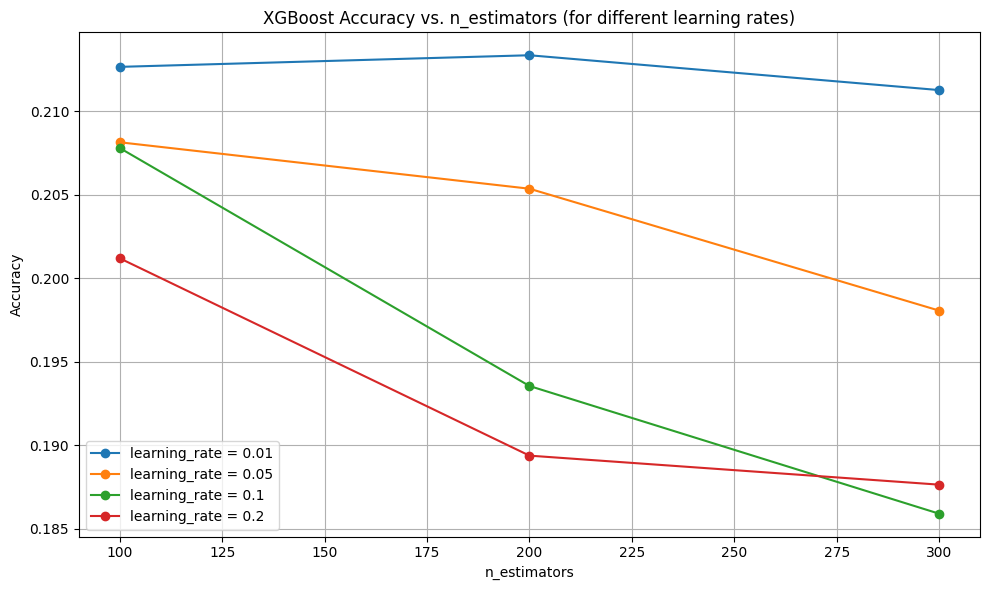

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Parameters to test
learning_rates = [0.01, 0.05, 0.1, 0.2]
n_estimators_range = [100, 200, 300]

# Store results
results = {}

for lr in learning_rates:
    accs = []
    for n in n_estimators_range:
        model = XGBClassifier(
            learning_rate=lr,
            n_estimators=n,
            max_depth=6,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
        model.fit(X_train, y_train_enc)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test_enc, y_pred)
        accs.append(acc)
        print(f"learning_rate={lr}, n_estimators={n} → Accuracy: {acc:.4f}")
    results[str(lr)] = accs

# Plotting
plt.figure(figsize=(10, 6))
for lr, accs in results.items():
    plt.plot(n_estimators_range, accs, marker='o', label=f"learning_rate = {lr}")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("XGBoost Accuracy vs. n_estimators (for different learning rates)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

final_xgb = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=6,
    eval_metric='mlogloss',
    random_state=42
)
final_xgb.fit(X_train, y_train_enc)
y_pred = final_xgb.predict(X_test)

print("Final XGBoost Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Final XGBoost Accuracy: 0.2113


SVM Only → Accuracy: 0.2224
SVM + RF → Accuracy: 0.2248
SVM + RF + XGB → Accuracy: 0.2199


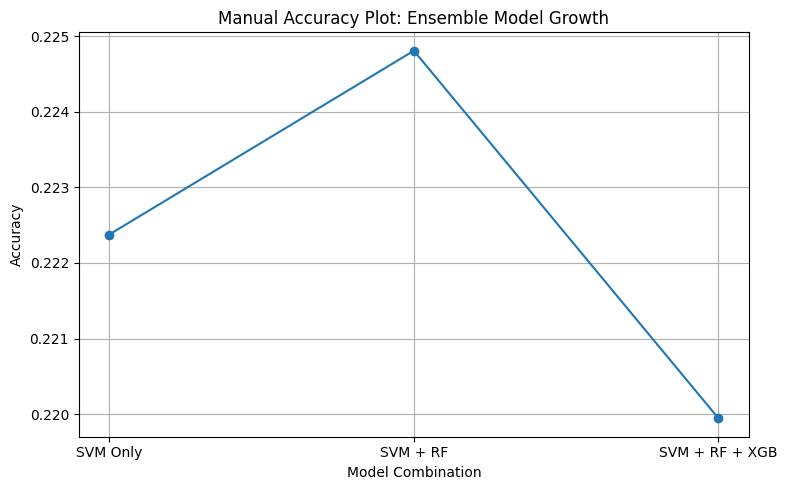

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Base models
svm_final = SVC(kernel='rbf', C=0.01, gamma='scale', probability=True, random_state=42)
rf_final = RandomForestClassifier(n_estimators=350, max_depth=4, random_state=42)
xgb_final = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=6, eval_metric='mlogloss', random_state=42)

# Define model groups to test
model_sets = [
    [('svm', svm_final)],
    [('svm', svm_final), ('rf', rf_final)],
    [('svm', svm_final), ('rf', rf_final), ('xgb', xgb_final)]
]

labels = ['SVM Only', 'SVM + RF', 'SVM + RF + XGB']
accuracies = []

# Evaluate each ensemble configuration
for label, models in zip(labels, model_sets):
    ensemble = VotingClassifier(estimators=models, voting='soft')
    ensemble.fit(X_train, y_train_enc)
    y_pred = ensemble.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"{label} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Manual Accuracy Plot: Ensemble Model Growth")
plt.xlabel("Model Combination")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


SVM Only (Stack) → Accuracy: 0.2241
SVM + RF (Stack) → Accuracy: 0.2241
SVM + RF + XGB (Stack) → Accuracy: 0.2199


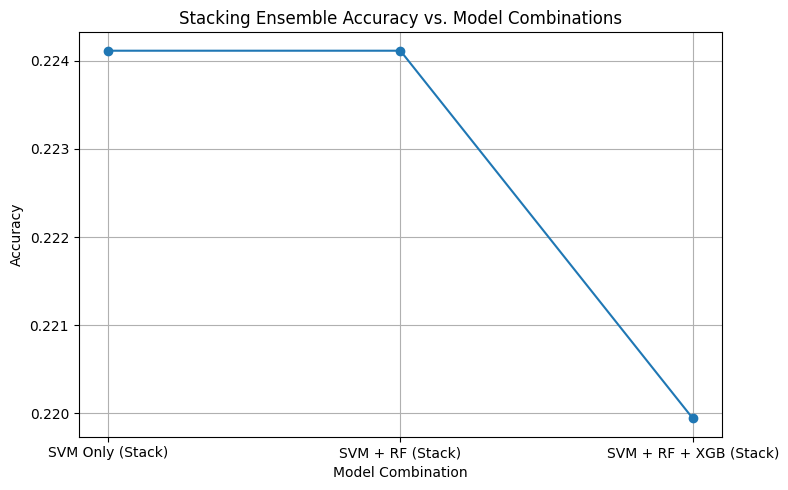

In [22]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Base models
svm_model = SVC(kernel='rbf', C=0.01, gamma='scale', probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=350, max_depth=4, random_state=42)
xgb_model = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=6, eval_metric='mlogloss', random_state=42)

# Meta-model
meta_model = LogisticRegression(max_iter=1000)

# Model sets
model_sets = [
    [('svm', svm_model)],
    [('svm', svm_model), ('rf', rf_model)],
    [('svm', svm_model), ('rf', rf_model), ('xgb', xgb_model)]
]

labels = ['SVM Only (Stack)', 'SVM + RF (Stack)', 'SVM + RF + XGB (Stack)']
accuracies = []

# Evaluate stacking models
for label, base_models in zip(labels, model_sets):
    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        passthrough=False,  # use base model predictions only
        cv=5,
        n_jobs=-1
    )
    stack.fit(X_train, y_train_enc)
    y_pred = stack.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"{label} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Stacking Ensemble Accuracy vs. Model Combinations")
plt.xlabel("Model Combination")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Architecture (50,) → Accuracy: 0.2029
Architecture (100,) → Accuracy: 0.1981
Architecture (150,) → Accuracy: 0.1911


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (100, 50) → Accuracy: 0.1703


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (128, 64) → Accuracy: 0.1696


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (128, 64, 32) → Accuracy: 0.1571
Architecture (256, 128, 64) → Accuracy: 0.1449


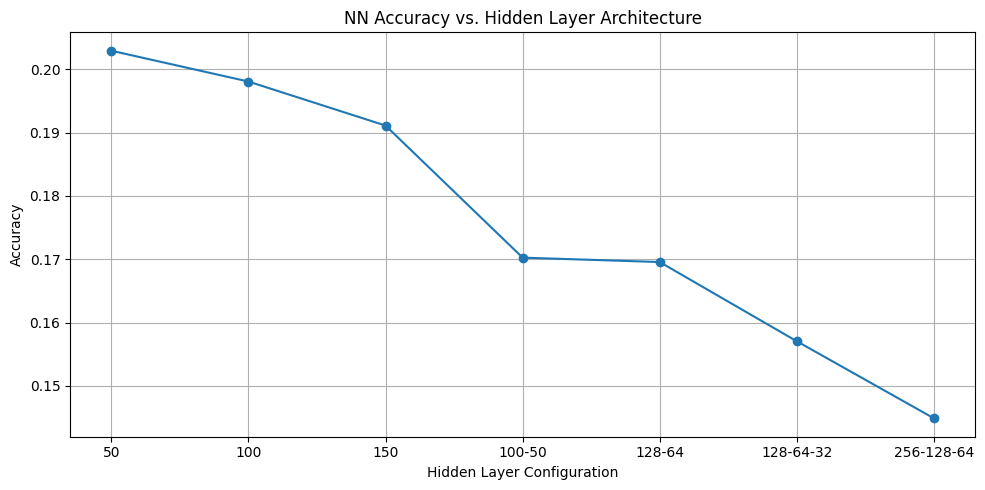

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define architectures to test
architectures = [
    (50,),
    (100,),
    (150,),
    (100, 50),
    (128, 64),
    (128, 64, 32),
    (256, 128, 64)
]

labels = ['50', '100', '150', '100-50', '128-64', '128-64-32', '256-128-64']
accuracies = []

# Train and evaluate each
for arch in architectures:
    nn = MLPClassifier(hidden_layer_sizes=arch, max_iter=500, random_state=42)
    nn.fit(X_train, y_train_enc)
    y_pred = nn.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"Architecture {arch} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("NN Accuracy vs. Hidden Layer Architecture")
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Architecture (64,) → Accuracy: 0.2168
Architecture (128,) → Accuracy: 0.2165
Architecture (256,) → Accuracy: 0.2137
Architecture (512,) → Accuracy: 0.1869
Architecture (128, 64) → Accuracy: 0.1987
Architecture (128, 64, 32) → Accuracy: 0.1807
Architecture (256, 128, 64) → Accuracy: 0.1678
Architecture (16, 8) → Accuracy: 0.2269
Architecture (8, 8) → Accuracy: 0.2269
Architecture (4, 4) → Accuracy: 0.2234
Architecture (4, 8) → Accuracy: 0.2245
Architecture (8, 8, 16) → Accuracy: 0.2262
Architecture (8, 8, 8) → Accuracy: 0.2238
Architecture (8, 8, 4) → Accuracy: 0.2248
Architecture (8, 8, 8, 8) → Accuracy: 0.2210
Architecture (4, 4, 4, 4) → Accuracy: 0.1981


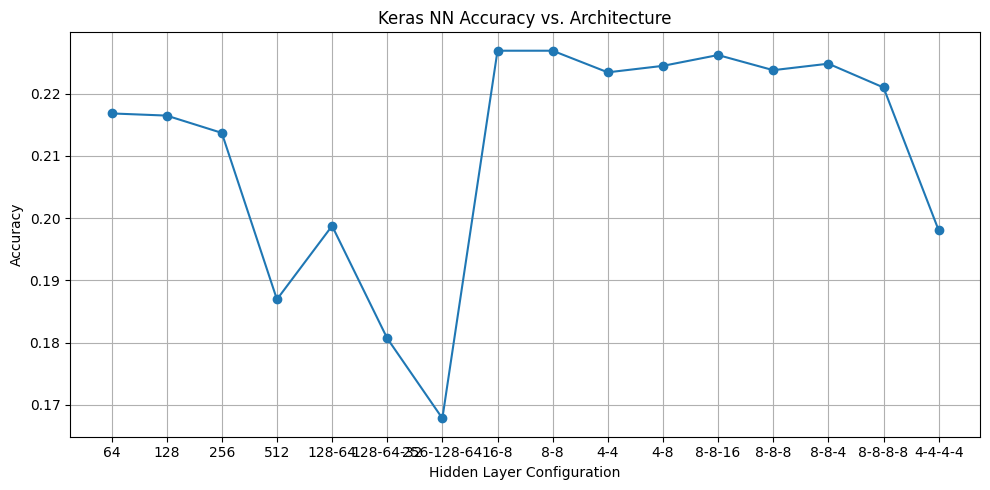

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure y is one-hot encoded
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Define different architectures to test
architectures = [
    (64,),
    (128,),
    (256,),
    (512,),
    (128, 64),
    (128, 64, 32),
    (256, 128, 64),
    (16,8),
    (8,8),
    (4,4),
    (4,8),
    (8,8,16),
    (8,8,8),
    (8,8,4),
    (8,8,8,8),
    (4,4,4,4)
]

labels = ['64', '128','256','512', '128-64', '128-64-32', '256-128-64','16-8','8-8','4-4','4-8','8-8-16','8-8-8','8-8-4','8-8-8-8','4-4-4-4']
accuracies = []

# Loop through each architecture
for arch in architectures:
    model = Sequential()
    model.add(Dense(arch[0], activation='relu', input_shape=(X_train.shape[1],)))
    
    for units in arch[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train_cat, epochs=30, batch_size=32, verbose=0)  # no validation for simplicity
    
    loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
    accuracies.append(acc)
    print(f"Architecture {arch} → Accuracy: {acc:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Keras NN Accuracy vs. Architecture")
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Architecture (64,) with dropout+BN → Accuracy: 0.2213
Architecture (128,) with dropout+BN → Accuracy: 0.2206
Architecture (256,) with dropout+BN → Accuracy: 0.2158
Architecture (512,) with dropout+BN → Accuracy: 0.2199
Architecture (128, 64) with dropout+BN → Accuracy: 0.2206
Architecture (128, 64, 32) with dropout+BN → Accuracy: 0.2196
Architecture (256, 128, 64) with dropout+BN → Accuracy: 0.2210
Architecture (16, 8) with dropout+BN → Accuracy: 0.2248
Architecture (8, 8) with dropout+BN → Accuracy: 0.2245
Architecture (4, 4) with dropout+BN → Accuracy: 0.2210
Architecture (4, 8) with dropout+BN → Accuracy: 0.2234
Architecture (8, 8, 16) with dropout+BN → Accuracy: 0.2213
Architecture (8, 8, 8) with dropout+BN → Accuracy: 0.2227
Architecture (8, 8, 4) with dropout+BN → Accuracy: 0.2245
Architecture (8, 8, 8, 8) with dropout+BN → Accuracy: 0.2203
Architecture (4, 4, 4, 4) with dropout+BN → Accuracy: 0.2210


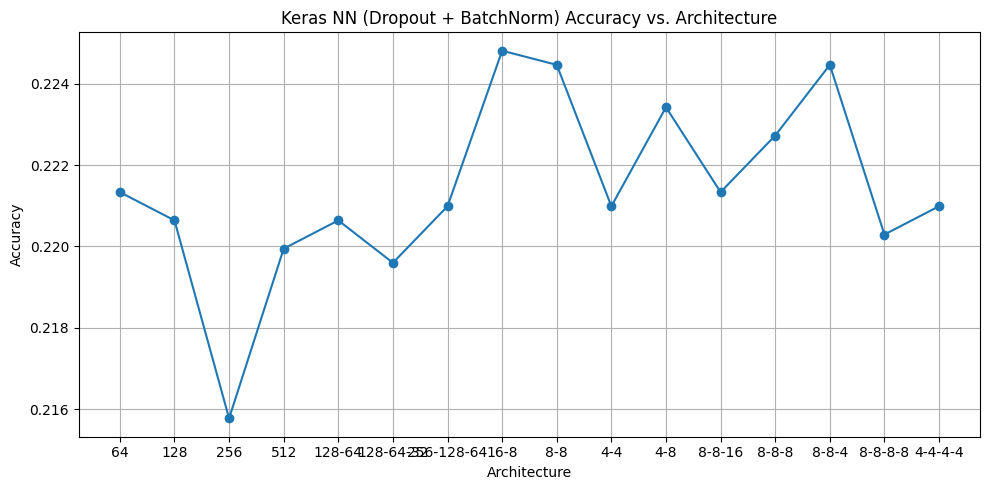

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Architectures
architectures = [
    (64,),
    (128,),
    (256,),
    (512,),
    (128, 64),
    (128, 64, 32),
    (256, 128, 64),
    (16,8),
    (8,8),
    (4,4),
    (4,8),
    (8,8,16),
    (8,8,8),
    (8,8,4),
    (8,8,8,8),
    (4,4,4,4)
]

labels = ['64', '128','256','512', '128-64', '128-64-32', '256-128-64','16-8','8-8','4-4','4-8','8-8-16','8-8-8','8-8-4','8-8-8-8','4-4-4-4']
accuracies = []

# Loop and evaluate
for arch in architectures:
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for i, units in enumerate(arch):
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())       # Normalize output
        model.add(Dropout(0.3))               # Drop 30% of neurons

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train_cat, epochs=30, batch_size=32, verbose=0)
    loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
    accuracies.append(acc)
    print(f"Architecture {arch} with dropout+BN → Accuracy: {acc:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Keras NN (Dropout + BatchNorm) Accuracy vs. Architecture")
plt.xlabel("Architecture")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Build model (best: 128-64-32)
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("Tuned Keras Model Accuracy (EarlyStopping + LR Scheduler): %.4f" % acc)


Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1324 - loss: 2.7838 - val_accuracy: 0.2163 - val_loss: 2.1433 - learning_rate: 0.0010
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1802 - loss: 2.2685 - val_accuracy: 0.2224 - val_loss: 2.0958 - learning_rate: 0.0010
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2059 - loss: 2.1570 - val_accuracy: 0.2320 - val_loss: 2.0831 - learning_rate: 0.0010
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2087 - loss: 2.1285 - val_accuracy: 0.2350 - val_loss: 2.0844 - learning_rate: 0.0010
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2245 - loss: 2.1021 - val_accuracy: 0.2311 - val_loss: 2.0850 - learning_rate: 0.0010
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2208 - loss: 2.0902 - val_accuracy: 0.2328 - val_loss: 2.0854 - learning_rate: 0.0010
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2234 - loss: 2.

In [33]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Reshape input to 3D (samples, features, 1 channel)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_reshaped, y_train_cat, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("CNN Accuracy (1D): %.4f" % acc)


Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1665 - loss: 2.3927 - val_accuracy: 0.1990 - val_loss: 2.2300
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2110 - loss: 2.1289 - val_accuracy: 0.2076 - val_loss: 2.1048
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2231 - loss: 2.0988 - val_accuracy: 0.2259 - val_loss: 2.0837
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2311 - loss: 2.0801 - val_accuracy: 0.2289 - val_loss: 2.0982
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2234 - loss: 2.0796 - val_accuracy: 0.2302 - val_loss: 2.0896
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2399 - loss: 2.0602 - val_accuracy: 0.2346 - val_loss: 2.0942
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2344 - loss: 2.0654 - val_accuracy: 0.2281 - val_loss: 2.0988
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2426 - loss: 2.0715 - val_accuracy: 0.

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Reshape input to 3D for Conv1D
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build simplified, regularized CNN
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_reshaped, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("Simplified CNN Accuracy: %.4f" % acc)


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1359 - loss: 2.7638 - val_accuracy: 0.2207 - val_loss: 2.3352
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1932 - loss: 2.2633 - val_accuracy: 0.2224 - val_loss: 2.2915
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2159 - loss: 2.2246 - val_accuracy: 0.2263 - val_loss: 2.2422
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2179 - loss: 2.1935 - val_accuracy: 0.2276 - val_loss: 2.2164
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2332 - loss: 2.1821 - val_accuracy: 0.2094 - val_loss: 2.1894
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2266 - loss: 2.1726 - val_accuracy: 0.2276 - val_loss: 2.1687
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2233 - loss: 2.1702 - val_accuracy: 0.2272 - val_loss: 2.1647
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2367 - loss: 2.1504 - val_accuracy: 0.2237 - v

In [35]:
import numpy as np

def tabular_to_image(X, image_size=(8, 8)):
    padded = np.zeros((X.shape[0], image_size[0] * image_size[1]))
    padded[:, :X.shape[1]] = X  # pad with zeros if needed
    return padded.reshape((X.shape[0], image_size[0], image_size[1], 1))
X_train_img = tabular_to_image(X_train)
X_test_img = tabular_to_image(X_test)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Build CNN
model = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=(8, 8, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_img, y_train_cat, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test_img, y_test_cat, verbose=0)
print("Grayscale CNN Accuracy (8x8 images): %.4f" % acc)



Epoch 1/30


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1804 - loss: 2.2735 - val_accuracy: 0.2029 - val_loss: 2.1247
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2100 - loss: 2.1070 - val_accuracy: 0.2198 - val_loss: 2.0875
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2206 - loss: 2.0823 - val_accuracy: 0.2220 - val_loss: 2.0869
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2246 - loss: 2.0846 - val_accuracy: 0.2263 - val_loss: 2.1011
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2319 - loss: 2.0715 - val_accuracy: 0.2333 - val_loss: 2.0926
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2174 - loss: 2.0770 - val_accuracy: 0.2311 - val_loss: 2.0904
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2337 - loss: 2.0639 - val_accuracy: 0.2354 - val_loss: 2.0849
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2319 - loss: 2.0669 - val_accuracy: 0.228

conv32 → Accuracy: 0.2199
conv32-dropout → Accuracy: 0.2248
conv32+64 → Accuracy: 0.2227
conv32+64-dropout → Accuracy: 0.2199
conv64+128-dropout → Accuracy: 0.2252


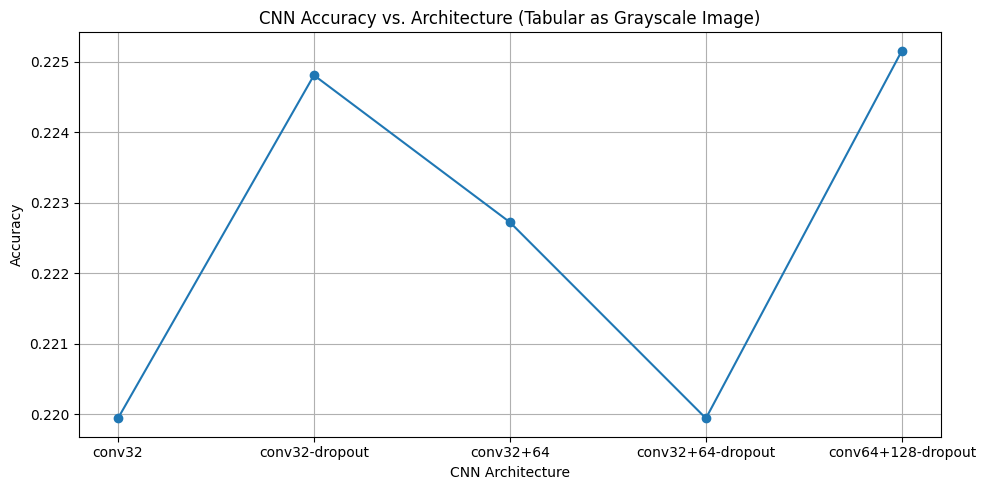

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Make sure data is ready
X_train_img = tabular_to_image(X_train)
X_test_img = tabular_to_image(X_test)

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Define architectures to test
architectures = [
    'conv32',
    'conv32-dropout',
    'conv32+64',
    'conv32+64-dropout',
    'conv64+128-dropout'
]
accuracies = []

# Evaluate each architecture
for name in architectures:
    model = Sequential()
    model.add(Input(shape=(8, 8, 1)))

    if name == 'conv32':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Flatten())
    
    elif name == 'conv32-dropout':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dropout(0.3))
    
    elif name == 'conv32+64':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())

    elif name == 'conv32+64-dropout':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dropout(0.3))

    elif name == 'conv64+128-dropout':
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_img, y_train_cat, epochs=20, batch_size=32, verbose=0)
    loss, acc = model.evaluate(X_test_img, y_test_cat, verbose=0)
    accuracies.append(acc)
    print(f"{name} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(architectures, accuracies, marker='o', linestyle='-')
plt.title("CNN Accuracy vs. Architecture (Tabular as Grayscale Image)")
plt.xlabel("CNN Architecture")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
